<a href="https://colab.research.google.com/github/KlyachevDmitry/Neural_Networks_and_CV/blob/master/global_wheat_detection_SSD300_clearv3_alb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import os
import sys
import json
import ast
import numba
import re
import matplotlib.pyplot as plt

from numba import jit
from typing import List, Union, Tuple

import cv2
import numpy as np
import random
# from PIL import Image, ImageDraw, ImageFile
# # fix bugs with loading png files
# ImageFile.LOAD_TRUNCATED_IMAGES = True

import pandas as pd
from sklearn.model_selection import KFold

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, Subset, RandomSampler
from torch.hub import load_state_dict_from_url
from torchvision.ops.boxes import batched_nms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchsummary import summary

!pip install -U git+https://github.com/albu/albumentations --no-cache-dir -q
import albumentations as A


     |████████████████████████████████| 952kB 5.5MB/s 


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
!pip install -q kaggle==1.5.10 --force-reinstall
!mkdir -p ~/.kaggle

with open('kaggle.json', 'w') as f:
  json.dump({"username":"klyachevdmitry","key":"a77d2a248c62a183ab6c9a3ed02be89a"}, f)

!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle competitions download -c global-wheat-detection
!unzip -q global-wheat-detection.zip -d global-wheat-detection
!ls

     |████████████████████████████████| 61kB 2.9MB/s 
     |████████████████████████████████| 153kB 7.7MB/s 
     |████████████████████████████████| 235kB 40.0MB/s 
     |████████████████████████████████| 61kB 5.7MB/s 
     |████████████████████████████████| 81kB 6.7MB/s 
     |████████████████████████████████| 153kB 54.1MB/s 
     |████████████████████████████████| 184kB 54.9MB/s 
     |████████████████████████████████| 61kB 5.4MB/s 
     |████████████████████████████████| 81kB 6.3MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
kaggle.json
 97% 591M/607M [00:04<00:00, 165MB/s]
100% 607M/607M [00:04<00:00, 134MB/s]
global-wheat-detection	global-wheat-detection.zip  kaggle.json  sample_data


In [ ]:
class ResNet50Backbone(nn.Module):

    def __init__(self, freeze=True):
        super(ResNet50Backbone, self).__init__()

        model = models.resnet50(pretrained=True)
        if freeze:
            model.requires_grad_(False)
        else:
            for name, parameter in model.named_parameters():
                if 'layer2' not in name and 'layer3' not in name and 'layer4' not in name:
                    parameter.requires_grad_(False)
        self.x = nn.Sequential(*list(model.children())[:7])
        # our neck
        # output channels for each additional features block
        self.out_channels = [1024, 512, 512, 256, 256, 256]
        # remove strides to get correct feature spatial size
        conv4_block1 = self.x[-1][0]
        conv4_block1.conv1.stride = (1, 1)
        conv4_block1.conv2.stride = (1, 1)
        conv4_block1.downsample[0].stride = (1, 1)

    def forward(self, x):
        return self.x(x)

In [ ]:
class SSD(nn.Module):

    def __init__(self, backbone, classes=2, freeze=True):
        super(SSD, self).__init__()

        self.base = backbone

        self.classes = classes  
        self.num_defaults = [4, 6, 6, 6, 4, 4]
        self.additional_blocks = []
        self.loc = []
        self.conf = []

        # adding additional blocks before loc and conf heads
        self.build_additional_features(self.base.out_channels)

        # creating loc and conf heads
        for nboxes, channels in zip(self.num_defaults, self.base.out_channels):
            self.loc.append(nn.Conv2d(channels, nboxes * 4, kernel_size=3, padding=1))
            self.conf.append(nn.Conv2d(channels, nboxes * self.classes, kernel_size=3, padding=1))

        self.loc = nn.ModuleList(self.loc)
        self.conf = nn.ModuleList(self.conf)

        self._init_weights()

    def build_additional_features(self, input_size):
        for i, (input_size, output_size, channels) in enumerate(zip(input_size[:-1], input_size[1:], [256, 256, 128, 128, 128])):
            # we dont use bias because we use batchnorm that should center data
            # here we first reduce number of channels and then expand, like in autoencoder
            if i < 3:
                layer = nn.Sequential(
                    nn.Conv2d(input_size, channels, kernel_size=1, bias=False),
                    nn.BatchNorm2d(channels),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(channels, output_size, kernel_size=3, padding=1, stride=2, bias=False),
                    nn.BatchNorm2d(output_size),
                    nn.ReLU(inplace=True),
                )
            else:
                layer = nn.Sequential(
                    nn.Conv2d(input_size, channels, kernel_size=1, bias=False),
                    nn.BatchNorm2d(channels),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(channels, output_size, kernel_size=3, bias=False),
                    nn.BatchNorm2d(output_size),
                    nn.ReLU(inplace=True),
                )

            self.additional_blocks.append(layer)

        self.additional_blocks = nn.ModuleList(self.additional_blocks)

    def _init_weights(self):
        # initialize weight for convolutions
        layers = [*self.additional_blocks, *self.loc, *self.conf]
        for layer in layers:
            for param in layer.parameters():
                # check for convolution layer
                if param.dim() > 1: nn.init.xavier_uniform_(param)

    def bbox_view(self, src):
        # Apply heads and reshape
        ret = []
        for s, l, c in zip(src, self.loc, self.conf):
            ret.append((l(s).view(s.size(0), 4, -1), c(s).view(s.size(0), self.classes, -1)))

        locs, confs = list(zip(*ret))
        # .contiguous() used cause some operation not creating new tensor 
        # but creating some memory mapping of current. And .contiguous() basicly apply
        # this mapping and create new tensor
        locs, confs = torch.cat(locs, 2).contiguous(), torch.cat(confs, 2).contiguous()
        return locs, confs

    def forward(self, x):
        x = self.base(x)
        
        # creating different feature levels
        detection_feed = [x]
        for i,l in enumerate(self.additional_blocks):
            x = l(x)
            detection_feed.append(x)

        # Feature Map 38x38x4, 19x19x6, 10x10x6, 5x5x6, 3x3x4, 1x1x4
        locs, confs = self.bbox_view(detection_feed)

        # For SSD 300, shall return nbatch x 8732 x {classes, locations} results
        return locs, confs


Checking model

In [ ]:
# x = torch.rand((2,3,300,300))
# l,c = SSD(ResNet50Backbone())(x)
# summary(SSD(ResNet50Backbone()).to(device), [[3, 300,300]])

### Visualize SSD300

In [ ]:
!pip install torchviz

     |████████████████████████████████| 51kB 3.6MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp37-none-any.whl size=3520 sha256=e44ac01a6d11ed735ef18a1ddb451c8b357220441e13fb638097300034a0bdce
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


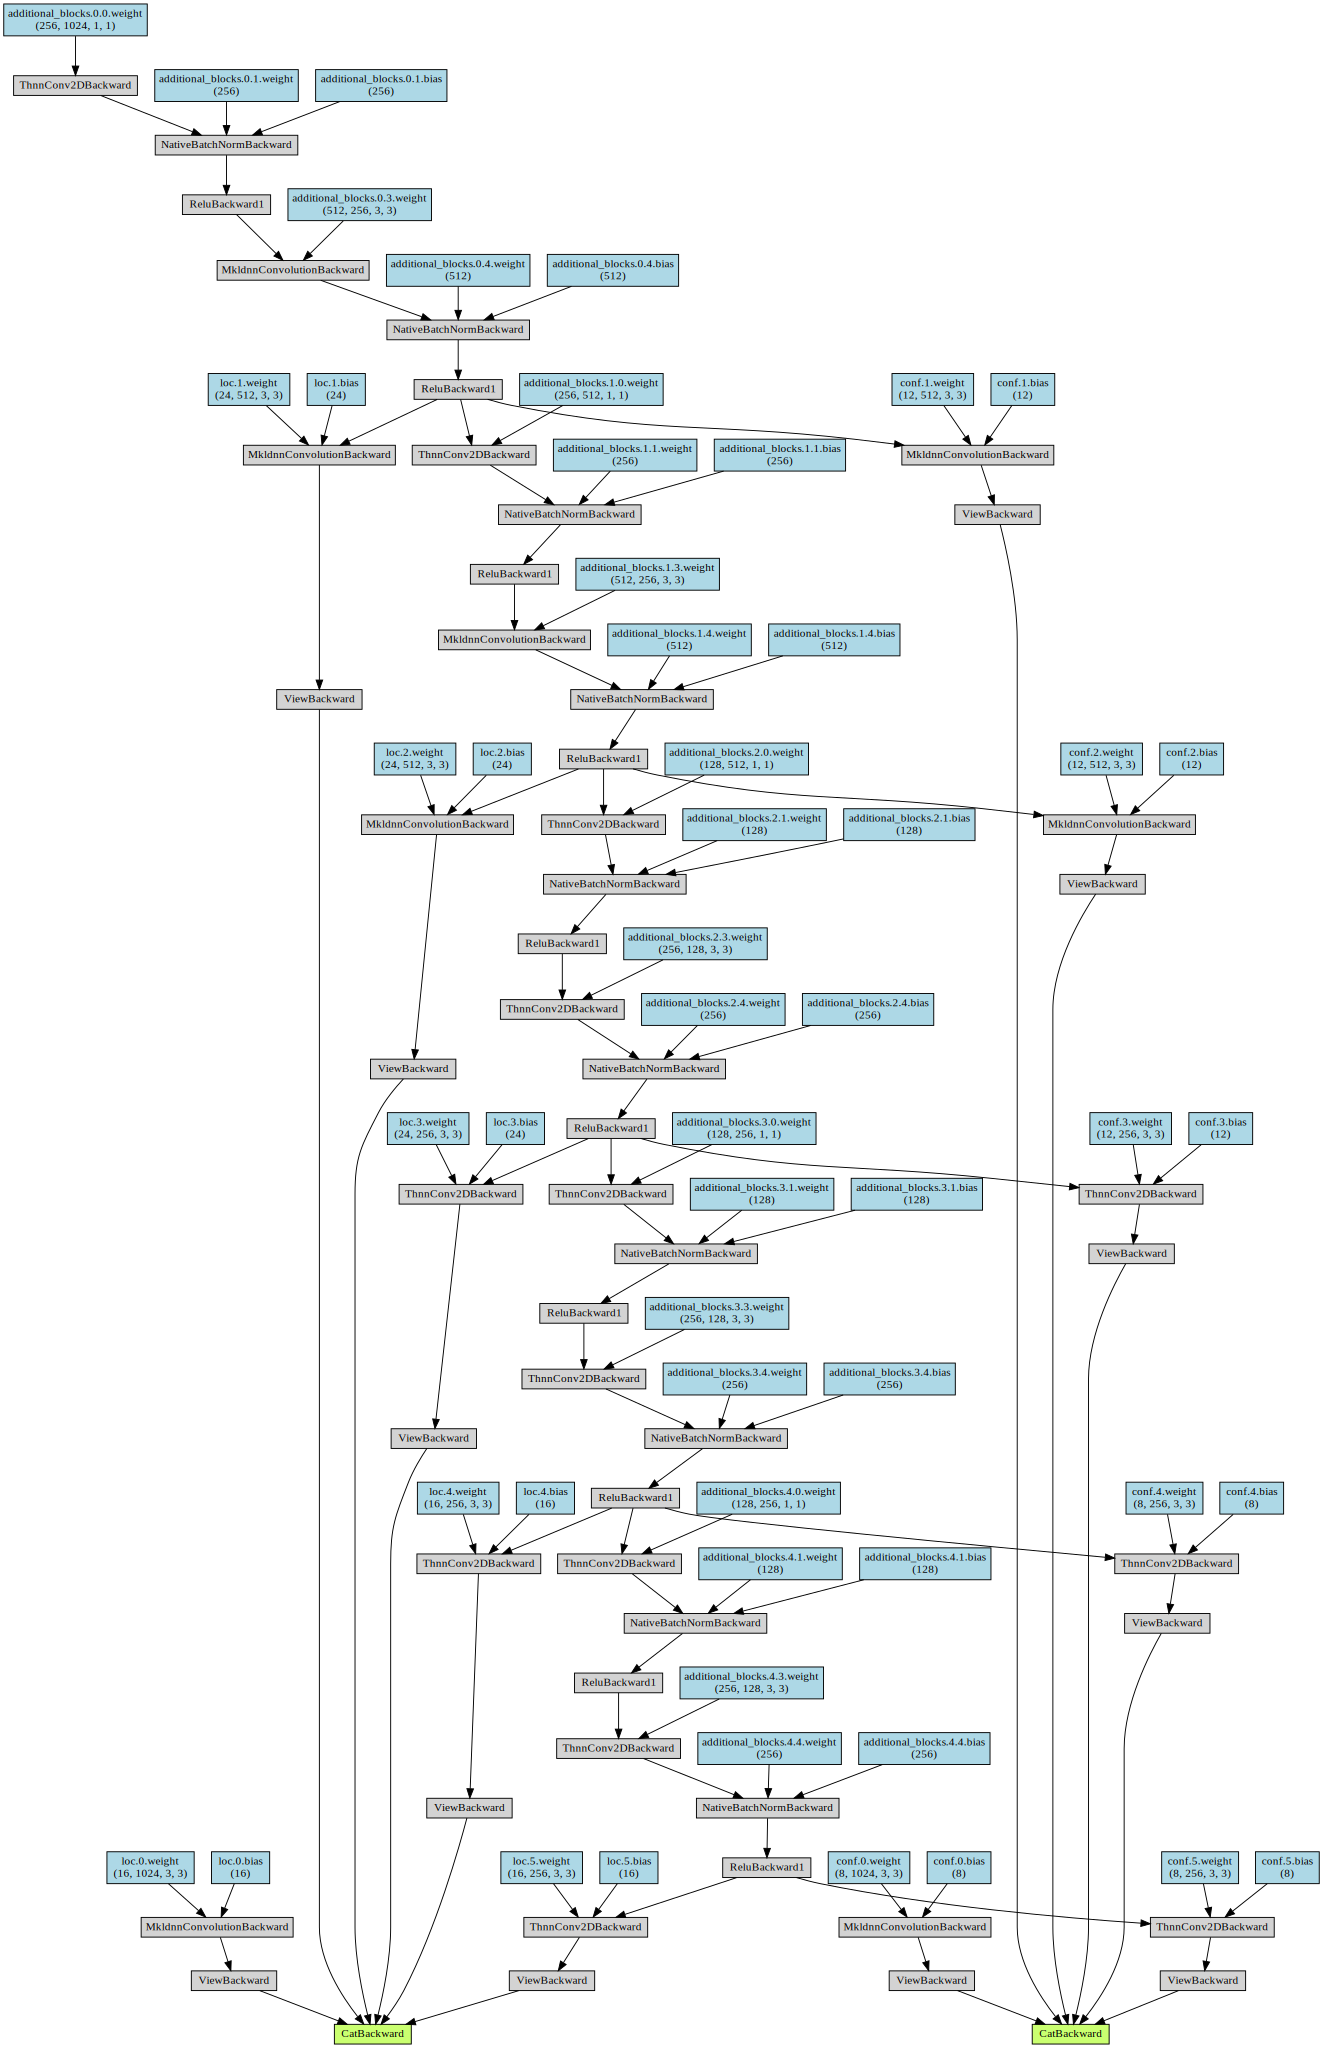

In [ ]:
from torchviz import make_dot
model_test = SSD(ResNet50Backbone())
model_test.eval()
out = model_test(torch.rand(1, 3,300,300))
make_dot(out, params=dict(list(model_test.named_parameters())))

In [ ]:
# https://netron.app/
# model_test.eval()
# dummy_input = torch.randn(1, 3, 300, 300)
# torch.onnx.export(model_test, dummy_input, 'ssd300_netron.onnx', verbose=False, output_names=["rboxes", "rlabels"])

### Make Default Boxes

In [ ]:
from math import sqrt
import itertools

class DefaultBoxes(object):
    def __init__(self, fig_size, feat_size, aspect_ratios, \
                       scale_min=0.07, scale_max=0.9):

        self.feat_size = feat_size
        self.fig_size = fig_size
        self.scale_min = scale_min
        self.scale_max = scale_max

        self.aspect_ratios = aspect_ratios

        self.default_boxes = []

        for idx, sfeat in enumerate(self.feat_size):
            sk = scale_min + ((scale_max - scale_min)/(len(self.feat_size)-1))*(idx)
            sk_next = scale_min + ((scale_max - scale_min)/(len(self.feat_size)-1))*(idx+1)
            
            all_sizes = []
            for alpha in self.aspect_ratios[idx]:
                w, h = sk*sqrt(alpha), sk/sqrt(alpha)
                all_sizes.append((w,h))
            # for aspect 1 adding additional box
            sk = sqrt(sk*sk_next)
            w, h = sk*sqrt(1.), sk/sqrt(1.)
            all_sizes.append((w,h))
            
            for w, h in all_sizes:
                for i, j in itertools.product(range(sfeat), repeat=2):
                    cx, cy = (j+0.5)/sfeat, (i+0.5)/sfeat
                    self.default_boxes.append((cx, cy, w, h))
        # выходят боксами за границу
        self.dboxes = torch.tensor(self.default_boxes)
        # make values in interval [0,1]
        self.dboxes.clamp_(min=0, max=1)
        # For IoU calculation
        # не выходят за границу
        self.dboxes_ltrb = self.dboxes.clone()
        self.dboxes_ltrb[:, 0] = self.dboxes[:, 0] - 0.5 * self.dboxes[:, 2]
        self.dboxes_ltrb[:, 1] = self.dboxes[:, 1] - 0.5 * self.dboxes[:, 3]
        self.dboxes_ltrb[:, 2] = self.dboxes[:, 0] + 0.5 * self.dboxes[:, 2]
        self.dboxes_ltrb[:, 3] = self.dboxes[:, 1] + 0.5 * self.dboxes[:, 3]
        self.dboxes_ltrb.clamp_(min=0, max=1)
        # LTRB boxes added clamp, cause new values can be out of interval [0,1]

    def __call__(self, order="ltrb"):
        if order == "ltrb": return self.dboxes_ltrb
        if order == "xywh": return self.dboxes

def default_boxes_300():
    # we use default values
    figsize = 300
    feat_size = [38, 19, 10, 5, 3, 1]
    # length matched with num_defaults parametr of SSD model (dont forget about + 1 for aspect ration 1)
    aspect_ratios = [[1.,2.,0.5], [1.,2.,0.5,3.,1./3], [1.,2.,0.5,3.,1./3], [1.,2.,0.5,3.,1./3], [1.,2.,0.5], [1.,2.,0.5]]
    scale_min=0.07
    scale_max=0.9
    dboxes = DefaultBoxes(figsize, feat_size, aspect_ratios, scale_min=scale_min, scale_max=scale_max)
    return dboxes

In [ ]:
default_boxes_300().dboxes.shape

torch.Size([8732, 4])

In [ ]:
def calc_iou_tensor(box1, box2):
    """ param: box1  tensor (N, 4) (x1,y1,x2,y2)
        param: box2  tensor (M, 4) (x1,y1,x2,y2)
        output: tensor (N, M)
    """
    N = box1.size(0)
    M = box2.size(0)

    box1 = box1.unsqueeze(1).expand(-1, M, -1)
    box2 = box2.unsqueeze(0).expand(N, -1, -1)

    # Left Top & Right Bottom
    lt = torch.max(box1[:,:,:2], box2[:,:,:2])
    rb = torch.min(box1[:,:,2:], box2[:,:,2:])

    delta = rb - lt
    delta[delta < 0] = 0
    intersect = delta[:,:,0]*delta[:,:,1]

    delta1 = box1[:,:,2:] - box1[:,:,:2]
    area1 = delta1[:,:,0]*delta1[:,:,1]
    delta2 = box2[:,:,2:] - box2[:,:,:2]
    area2 = delta2[:,:,0]*delta2[:,:,1]

    iou = intersect/(area1 + area2 - intersect)
    return iou


class BoxUtils:
    """
        Util to encode/decode target/result boxes

        param: dboxes - DefaultBoxes instance
    """

    def __init__(self, dboxes):
        self.dboxes = dboxes(order="ltrb")
        self.dboxes_xywh = dboxes(order="xywh")
        self.nboxes = self.dboxes.size(0)

    def encode(self, bboxes, labels_in, criteria = 0.5, num_classes=21):

        ious = calc_iou_tensor(bboxes, self.dboxes) # [N_bboxes, num_default_boxes]
        best_dbox_ious, best_dbox_idx = ious.max(dim=0) # [num_default_boxes], [num_default_boxes]
        best_bbox_ious, best_bbox_idx = ious.max(dim=1) # [N_bboxes], [N_bboxes]

        # set best ious 2.0
        # this needed to not filter out this bboxes on next step
        best_dbox_ious.index_fill_(0, best_bbox_idx, 2.0)

        # filter out dboxes with IoU <= criteria
        masks = best_dbox_ious > criteria
        # setting all labels of filtered out dboxes to zero(background)
        labels_out = torch.zeros(self.nboxes, dtype=torch.long)
        labels_out[masks] = labels_in[best_dbox_idx[masks]]

        # setting ghound trouth boxes on place of best matched default boxes
        # and convert (x1,y1,x2,y2) format to (xc,yc,w,h)

        bboxes_out = self.dboxes.clone()

        bboxes_out[masks, :] = bboxes[best_dbox_idx[masks], :]
        # Transform format ltrb to xywh format
        x, y, w, h = 0.5*(bboxes_out[:, 0] + bboxes_out[:, 2]), \
                     0.5*(bboxes_out[:, 1] + bboxes_out[:, 3]), \
                     -bboxes_out[:, 0] + bboxes_out[:, 2], \
                     -bboxes_out[:, 1] + bboxes_out[:, 3]

        # make coordinates to be offset to default boxes and encode "variance" for xy and wh
        bboxes_out[:, 0] = (x - self.dboxes_xywh[:, 0])/(self.dboxes_xywh[:, 2])
        bboxes_out[:, 1] = (y - self.dboxes_xywh[:, 1])/(self.dboxes_xywh[:, 3])

        bboxes_out[:, 2] = w/self.dboxes_xywh[:, 2]
        bboxes_out[:, 3] = h/self.dboxes_xywh[:, 3]

        return bboxes_out, labels_out

    def decode(self, bboxes):
        """

        """
        xy = self.dboxes_xywh[:,:2]
        wh = self.dboxes_xywh[:,2:]

 
        _xy = (bboxes[:,:2]*wh) + xy 
        _wh2 = bboxes[:,2:]*wh/2
        xy1 = (_xy - _wh2)
        xy2 = (_xy + _wh2)
        boxes = torch.cat([xy1,xy2],dim=-1)
        return boxes

In [ ]:
# class RandomHorizontalFlip(object):
#     def __init__(self, p=0.5):
#         self.p = p

#     def __call__(self, image, bboxes):
#         w,h = image.shape[:2]
#         if random.random() < self.p:
#             bboxes[:, 0], bboxes[:, 2] = w - bboxes[:, 2], w - bboxes[:, 0]
#             # return image.transpose(Image.FLIP_LEFT_RIGHT), bboxes
#             return cv2.flip(image, 1), bboxes
#         return image, bboxes

# class RandomCrop(object):
#     def __init__(self, p=0.5, size=(300,300)):
#         self.p = p
#         self.size = size

#     def __call__(self, img, bboxes, labels):
#         w,h = img.shape[:2]
#         if random.random() < self.p:
#             out_boxes = []
#             while not out_boxes:
#                 out_boxes = []
#                 left = random.random()*(w-self.size[0])
#                 top = random.random()*(h-self.size[1])
#                 right = left + self.size[0]
#                 bottom = top + self.size[0]

#                 out_labels = []
#                 for i,b in enumerate(bboxes):
#                     if (b[0] > right) or (b[2] < left) or (b[1] > bottom) or (b[3] < top)\
#                     or ((b[2]-b[0]) < 30) or ((b[3]-b[1]) < 30):
#                         continue

#                     nb = [0,0,0,0]
#                     nb[0] = max(b[0] - left,0)
#                     nb[2] = max(b[2] - left,0)
#                     nb[1] = max(b[1] - top,0)
#                     nb[3] = max(b[3] - top,0) 

#                     if (nb[2] > self.size[0]):
#                         nb[2] = self.size[0]
#                     if (nb[3] > self.size[1]):
#                         nb[3] = self.size[1]
#                     out_boxes.append(nb)
#                     out_labels.append(labels[i])
#                 print(left, top, right, bottom)
#                 img = img[int(top):int(bottom), int(left):int(right)]
#                 # img = image.crop((left, top, right, bottom))
#             return img, np.array(out_boxes, dtype=np.int32), out_labels, True
#         return img, bboxes, labels, False

class SSDTransform:
    def __init__(self, dboxes, size=(300,300), augmentation=False, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        self.size = size
        self.encoder = BoxUtils(dboxes)
        # base transform for images
        self.img_ts = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
        self.transforms_alb = A.Compose([A.RandomSunFlare(p=.1),
                       A.Cutout(num_holes=8, max_h_size=32, max_w_size=32, fill_value=0, p=0.3),
                      A.RandomFog(p=.1, alpha_coef=0.2), A.RandomBrightness(p=.1),
                      A.RandomResizedCrop(height = size[0], width = size[1], scale=(0.08, 1.0), ratio=(0.75, 1.3), interpolation=1, p=1.0),
                      A.Rotate(p=0.3, limit=90), A.RGBShift(p=.1), A.RandomSnow(p=.1),
                      A.HorizontalFlip(p=.3), A.VerticalFlip(p=.3), A.RandomContrast(limit = 0.5,p = .1),
                      A.HueSaturationValue(p=.1,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50), A.ToGray(p=0.01),
                      ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))
        self.classes = ["bg", "wheat"] 

        self.to_tensor = transforms.Compose([transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)])

        # self.hflip = RandomHorizontalFlip()
        self.augmentation = augmentation
       
    def box_normalize(self, img_shape, box):
        """Method to resize bounding box"""
        cols, rows = img_shape
        box = np.array([int(box[0])/cols,int(box[1])/rows,int(box[2])/cols,int(box[3])/rows])
        # box = A.normalize_bbox(box, rows, cols)
        return box
        
    def to_ltrb(self, out_boxes):
        """Convert xywh to ltrb"""
        out_boxes_copy = out_boxes.clone()
        out_boxes[:, 2] = out_boxes_copy[:, 0] + out_boxes_copy[:, 2]
        out_boxes[:, 3] = out_boxes_copy[:, 1] + out_boxes_copy[:, 3]
        return out_boxes

    def __call__(self, img, target):
        boxes = []
        labels = []

        if isinstance(target, dict) and 'annotation' in target:
            # voc bboxes annotation can be list if many or dict if one (never do like this)
            objects = target['annotation']['object'] if isinstance(target['annotation']['object'], list) else [target['annotation']['object']]
            for bb in objects:
                b = bb['bndbox']
                b = [int(b['xmin']),int(b['ymin']),int(b['xmax']),int(b['ymax'])]
                boxes.append(b)
                labels.append(self.classes.index(bb['name']))
        else:
            boxes = target[:]
            labels = [1]*len(boxes)

        boxes = torch.Tensor(boxes)
        boxes = self.to_ltrb(boxes)

        out_labels = []
        out_boxes = []

        if self.augmentation:
            # img, boxes = self.hflip(img, boxes)
            # img, boxes, out_labels, mod = self.crop(img, boxes, labels)
            # fix zero num bboxes
            num_bbox = 0         
            while num_bbox == 0:
              out_transform = self.transforms_alb(image=img, bboxes=boxes, class_labels=labels)
              img_prob = out_transform['image']
              boxes_prob = out_transform['bboxes']
              out_labels_prob = out_transform['class_labels']
              img_prob = self.to_tensor(img_prob).contiguous()
              num_bbox = len(boxes_prob)

            img = img_prob
            boxes = boxes_prob
            out_labels = out_labels_prob
            del img_prob, boxes_prob, out_labels_prob
        else:
            img = self.to_tensor(img).contiguous() 
            out_labels = labels
        shape = img.shape[1:]
        # normalize
        for bb in boxes:
            out_boxes.append(self.box_normalize(shape, bb))

        out_boxes = torch.tensor(out_boxes, dtype=torch.float32)
        out_labels = torch.tensor(out_labels, dtype=torch.long)
        bbox, label = self.encoder.encode(out_boxes, out_labels, num_classes=len(self.classes))

        return img, (bbox, label)


In [ ]:
def get_bbox_from_csv(csv_path):
  df = pd.read_csv(csv_path)
  imgs_name = np.unique(df['image_id'])
  bboxs = {}
  for id in imgs_name:
    bbox_list = []
    for bbox_str in df.loc[df['image_id']==id, 'bbox']:
      bbox = ast.literal_eval(bbox_str)
      bbox_list.append(bbox)
    bboxs[id] = bbox_list
  return bboxs


class WheatDataset(Dataset):
  def __init__(self, root, transforms=None):
    self.root = root
    self.transforms = transforms
    # dict targets
    self.bbox = get_bbox_from_csv(os.path.join(root, 'train.csv'))
    # image names 
    imgs_names = list(os.listdir(os.path.join(root, 'train')))
    # get img only with bbox
    self.imgs_names = [i for i in imgs_names if i.split('.')[0] in self.bbox]

  def __getitem__(self, idx):
    img_path = os.path.join(self.root, 'train', self.imgs_names[idx])

    img = cv2.imread(img_path)
    bbox = self.bbox[self.imgs_names[idx].split('.')[0]]

    if self.transforms is not None:
        img, bbox = self.transforms(img, bbox)
    return img, bbox

  def __len__(self):
    '''this method return len of dataset'''
    return len(self.imgs_names)


In [ ]:
def test_dataloading(ds, dboxes, size=300, scale_xy=0.1, scale_wh=0.2):

    bu = BoxUtils(dboxes)

    def denorm(x):
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        return (x * std) + mean

    for i in range(5):
        img, ts = ds[i]

        bboxes, labels = ts[0],ts[1]
        img = (denorm(img.numpy().transpose(1, 2, 0))*255).astype(np.uint8) 
        h,w = img.shape[:2]

        res = bu.decode(bboxes)
        mask = (labels > 0)
        res = res[mask].numpy()
        for bb in res: 
            img = cv2.rectangle(img, (int(bb[0]*w), int(bb[1]*h)), (int(bb[2]*w), int(bb[3]*h)), (0, 255, 0), 2)
        img = img.get()
        plt.figure(figsize=(12,12))
        plt.imshow(img)
        plt.show()
        print('Shape:',img.shape,'Boxes:',len(bboxes))

# Show Dataset

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:645: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1701: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1727: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


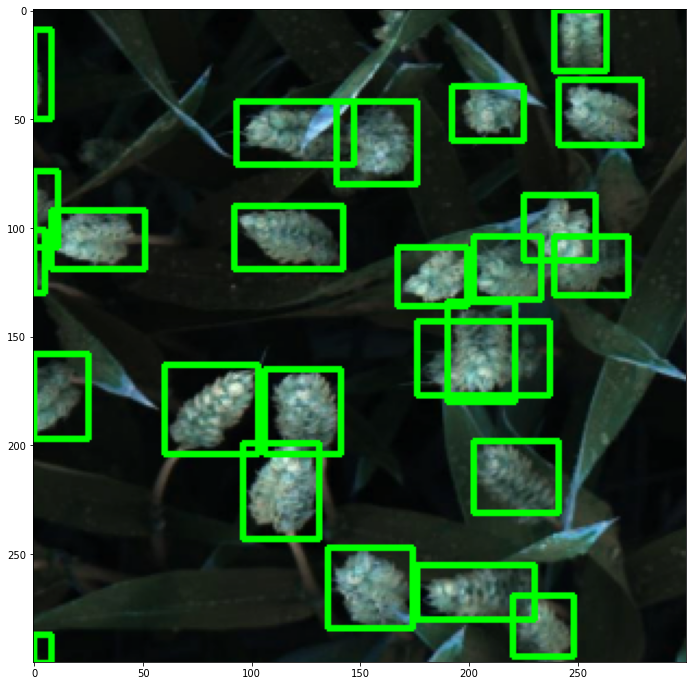

Shape: (300, 300, 3) Boxes: 8732


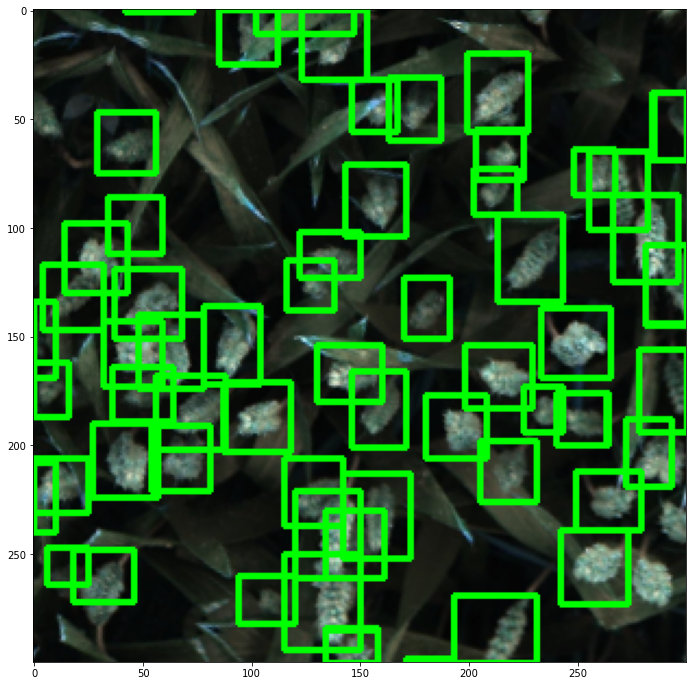

Shape: (300, 300, 3) Boxes: 8732


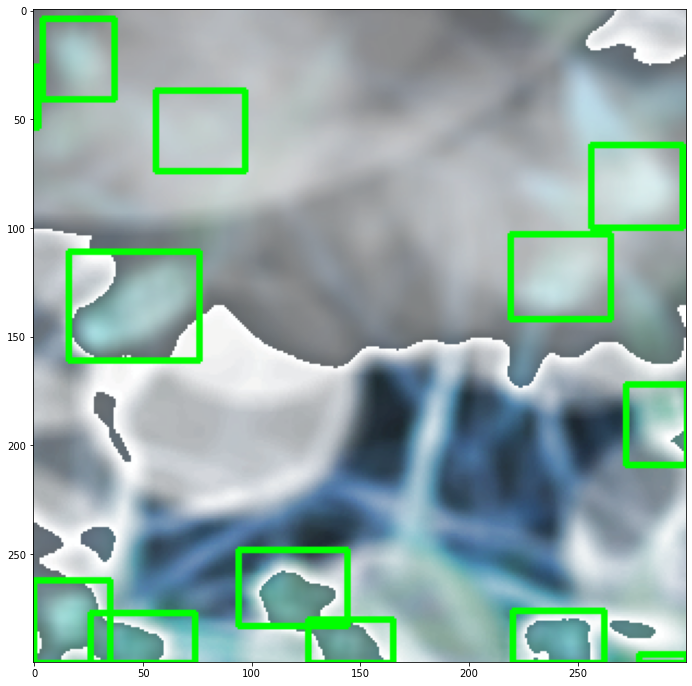

Shape: (300, 300, 3) Boxes: 8732


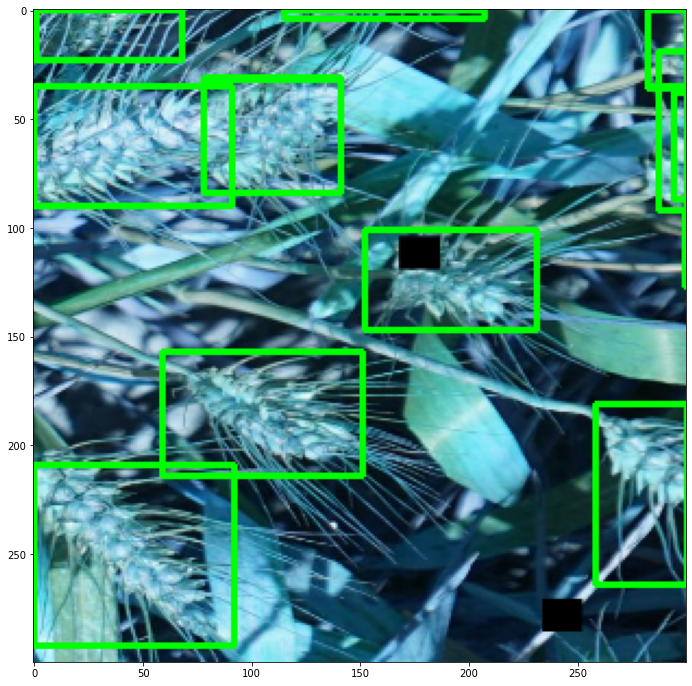

Shape: (300, 300, 3) Boxes: 8732


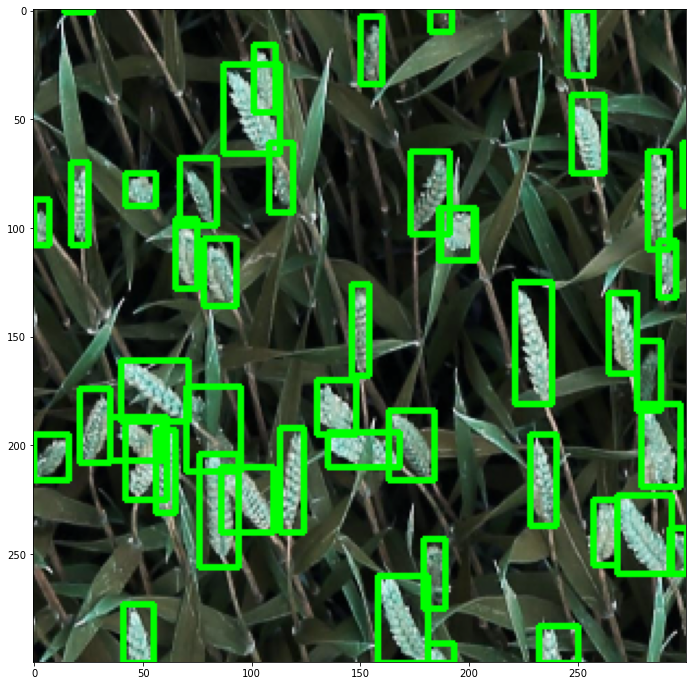

Shape: (300, 300, 3) Boxes: 8732


In [ ]:
dboxes = default_boxes_300()
ds = WheatDataset('./global-wheat-detection', transforms=SSDTransform(dboxes, size=(300, 300), augmentation=True))
test_dataloading(ds, dboxes)

In [ ]:
class FocalLoss(nn.Module):

    def __init__(self, gamma=2, size_average=False):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.size_average = size_average
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, input, target):
        ce = self.ce(input,target)
        # here we getting softmax by doing revert operation to log_e, e^log_e
        pt = (-1*ce).exp()
        loss = (1 - pt)**self.gamma * ce
        if self.size_average: 
            return loss.mean()
        else: 
            return loss

class Loss(nn.Module):
    """
        Implements the loss as the sum of the followings:
        1. Confidence Loss: All labels, with hard negative mining
        2. Localization Loss: Only on positive labels
        Suppose input dboxes has the shape 8732x4
    """
    def __init__(self, alpha=1, hard_negative_minning=True):
        super(Loss, self).__init__()
        self.alpha = alpha

        self.sl1_loss = nn.SmoothL1Loss(reduction='none')
        # self.con_loss = FocalLoss(size_average=False)
        self.con_loss = nn.CrossEntropyLoss(reduction='none')
        self.hard_negative_minning = hard_negative_minning

    def forward(self, ploc, plabel, gloc, glabel):
        """
            ploc, plabel: Nx4x8732, Nxlabel_numx8732
                predicted location and labels
            gloc, glabel: Nx4x8732, Nx8732
                ground truth location and labels
        """
        gloc = gloc.transpose(2,1)
        mask = glabel > 0
        # number of objects in the picture
        pos_num = mask.sum(dim=1)

        # sum on four coordinates, and mask
        sl1 = self.sl1_loss(ploc, gloc).sum(dim=1)
        sl1 = (mask.float()*sl1).sum(dim=1)

        # hard negative mining
        con = self.con_loss(plabel, glabel)
        if self.hard_negative_minning:
            # postive mask will never selected
            con_neg = con.clone()
            con_neg[mask] = 0
            con_neg_top, con_idx = con_neg.sort(dim=1, descending=True) # aka 8000,1734,2000,...

            _, con_rank = con_idx.sort(dim=1) # aka 1,2,0,..
            # number of negative three times positive
            neg_num = torch.clamp(3*pos_num, max=mask.size(1)).unsqueeze(-1) # Nx1

            neg_mask = con_rank < neg_num

            # summing positive confidence and negative confidence 
            closs = (con*(mask.float() + neg_mask.float())).sum(dim=1)
        else:
            closs = con.sum(dim=1)

        total_loss = sl1 + self.alpha*closs
        metrics = {'loc':sl1.mean().detach().item(), 'conf':closs.mean().detach().item()}

        # avoid no object detected
        # mask bbox above zero
        num_mask = (pos_num > 0).float()
        pos_num = pos_num.float().clamp(min=1e-6)
        # replace empty and divide by num prop_bbox
        ret = (total_loss*num_mask/pos_num).mean(dim=0)
        return ret,metrics

In [ ]:
@jit(nopython=True)
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()
        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area


@jit(nopython=True)
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

@jit(nopython=True)
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)

@jit(nopython=True)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision



In [ ]:
torch.manual_seed(42)
dboxes = default_boxes_300()
ds = WheatDataset('./global-wheat-detection', transforms=SSDTransform(dboxes, size=(300, 300), augmentation=True))

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:645: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1701: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1727: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


### Training

In [ ]:

torch.manual_seed(42)



train_size = int(0.8 * len(ds))
train_dataset, test_dataset = Subset(ds, list(range(train_size))), Subset(
    ds, list(range(train_size, len(ds))))

for train_dataset_idx, val_dataset_idx in KFold(n_splits=10, random_state=42, shuffle=True).split(train_dataset):

    train_dataset_fold = Subset(train_dataset, train_dataset_idx)
    val_dataset_fold = Subset(train_dataset, val_dataset_idx)


    rand_sampler = RandomSampler(train_dataset_fold)
    loader = DataLoader(train_dataset_fold, batch_size=8,
                        pin_memory=True, drop_last=True, sampler=rand_sampler)

    loader_val = DataLoader(val_dataset_fold, batch_size=8,
                        pin_memory=True, drop_last=False)
    print(f'Num image in train dataset: {len(train_dataset_fold)}. Num image in val dataset {len(val_dataset_fold)}', '\n')
    epochs = 5 

    model =  SSD(ResNet50Backbone(), classes=2, freeze=True)
    if os.path.exists('./ssd300.pth'):
        state = torch.load('./ssd300.pth')
        model.load_state_dict(state)
    model = model.to(device)
    loss_f = Loss(alpha=1, hard_negative_minning=True)

    # optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

    st = time.time()
    model.train()
    for e in range(epochs):
        t = 0
        et = time.time()
        loss_avg = 0
        loc_avg = 0
        conf_avg = 0
        for i, (img, target) in enumerate(loader):
            # if i == 1:
            #   break
            if i%50 == 0:
                print(f'Progress train on {e} epoch: {i/len(loader)*100:.2f}%')

            img = img.to(device)
            boxes, labels = target[0].to(device), target[1].to(device)

            # before each iteration we clear all gradients calculated before 
            optimizer.zero_grad()
            rboxes, rlabels = model(img)
            loss, metrics = loss_f(rboxes, rlabels, boxes, labels)
            
            if not np.isinf(loss.item()):
                # calculating gradients
                loss.backward()
                # optimizing
                optimizer.step()
                # .item() is simple way to get value from scalar
                loss_avg += loss.item()
                loc_avg += metrics['loc']
                conf_avg += metrics['conf']
                t += 1
        
        print(f'{(time.time()-et)/60}m Epoch: {e}/{epochs} | Loss:{loss_avg/t} | loc_avg: {loc_avg/t} | conf_avg: {conf_avg/t}')
        print('-'*80)
        try:
            torch.save(model.state_dict(), './ssd300.pth')
        except KeyboardInterrupt as e:
            print('SAVING!')
            torch.save(model.state_dict(), './ssd300.pth')
            raise e
        scheduler.step(loss_avg/t)

        loss_avg = 0
        loc_avg = 0
        conf_avg = 0
        iou_avg = 0
        if e != 0:
            et = time.time()
            model.eval()
            for j, (img, target) in enumerate(loader_val):
                if j%4 == 0:
                  print(f'Progress val {e} epoch: {j/len(loader_val)*100:.2f}%')
                img = img.to(device)
                boxes, labels = target[0].to(device), target[1].to(device)
                rboxes, rlabels = model(img)
                loss, metrics = loss_f(rboxes, rlabels, boxes, labels)
                if not np.isinf(loss.item()):
                    loss_avg += loss.item()
                    loc_avg += metrics['loc']
                    conf_avg += metrics['conf']
                    t += 1  
                    rboxes = rboxes.permute(0, 2, 1)
                    iou_avg += calculate_image_precision(rboxes.cpu().detach().numpy()[0], boxes.cpu().detach().numpy()[0], 
                                                    thresholds = (0.5, 0.60, 0.65, 0.70, 0.75))
            print(f'{(time.time()-et)/60}m Epoch: {e}/{epochs} | Loss:{loss_avg/t} | loc_avg: {loc_avg/t} | conf_avg: {conf_avg/t} | iou_avg:{iou_avg/t}')
            print('='*100, '\n')
            model.train()

        
    print('Training time:', time.time()-st)

In [ ]:
torch.save(model.state_dict(), './ssd300.pth')

In [ ]:
!ls -lah ssd300.pth

###Visualization of the result (pytorch)


In [ ]:
# we use batches_nms cause we can have many classes of different objects
from torchvision.ops.boxes import batched_nms


def denorm(x):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    return (x * std) + mean


def test_pytorch(model_path, model_class, bu, input, num=6, thresh=0.7, iou_threshold=0.2, size=300, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    classes = [
        "bg", 'wheat'
    ]

    state = torch.load(model_path)
    model = model_class.cpu()
    model.load_state_dict(state)
    model.eval()
    img_ts = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])  
    total = 0
    iou_avg = 0
    for img, target in input:
        img = img.view((1,)+img.shape)
        st = time.time()
        rboxes, rlabels = model(img)
        print('Inference time:', time.time()-st)
        st = time.time()

        rboxes, rlabels = rboxes[0].transpose(1,0), rlabels[0]
        img = (denorm(img[0].numpy().transpose(1,2,0).copy())*255).astype(np.uint8)
        w,h = img.shape[:2]

        bboxes = bu.decode(rboxes)
        scores, labels = F.softmax(rlabels, dim=0).max(dim=0)
        mask = (labels > 0)
        labels = labels[mask]
        scores = scores[mask]
        bboxes = bboxes[mask]

        mask = (scores > thresh)
        labels = labels[mask]
        scores = scores[mask]
        bboxes = bboxes[mask]
        
        
        print('Boxes:',bboxes.shape[0])
        print('Mod time:', time.time()-st)
        st = time.time()
        idx = batched_nms(bboxes, scores, labels, iou_threshold=iou_threshold).numpy().astype(np.uint64)
        print('NMS time:', time.time()-st)
        labels = labels.detach().numpy().astype(np.uint8)
        scores = scores.detach().numpy()
        bboxes = bboxes.detach().numpy()

        for i in idx:
            b = bboxes[i] 
            img = cv2.rectangle(img, (int(b[0]*size), int(b[1]*size)), (int(b[2]*size), int(b[3]*size)), (0, 255, 0), 2)
            print(int(b[0]*size), int(b[1]*size), int(b[2]*size), int(b[3]*size), classes[labels[i]], scores[i])

        bboxs =  bu.decode(target[0])
        labels = target[1]
        for b, l in zip(bboxs, labels):

          if int(l) != 0:
              img = cv2.rectangle(img, (int(b[0]*size), int(b[1]*size)), (int(b[2]*size), int(b[3]*size)), (255, 0, 0), 2)       
        
        plt.imshow(img)
        plt.show()

        total += 1
        if total >= num:
            break

Inference time: 0.45503759384155273
Boxes: 16
Mod time: 0.0048673152923583984
NMS time: 0.0011630058288574219
4 98 56 140 wheat 0.84890777
169 160 220 200 wheat 0.61697054
66 110 114 166 wheat 0.5748173
206 255 246 302 wheat 0.5627453
272 196 301 237 wheat 0.5418035
237 121 295 169 wheat 0.51168644


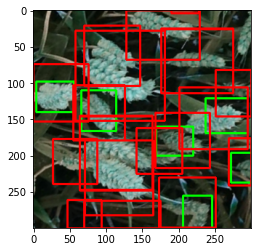

Inference time: 0.46371936798095703
Boxes: 15
Mod time: 0.004524707794189453
NMS time: 0.0009541511535644531
13 82 59 118 wheat 0.7019148
79 89 116 124 wheat 0.6502034
241 57 299 94 wheat 0.6466092
220 0 260 21 wheat 0.5180704
-2 18 34 50 wheat 0.51608497
158 94 198 132 wheat 0.5145572
8 269 45 300 wheat 0.5061113


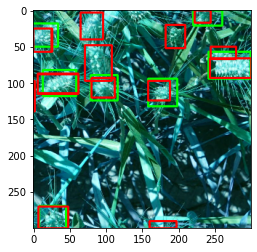

Inference time: 0.46061086654663086
Boxes: 0
Mod time: 0.00522613525390625
NMS time: 5.245208740234375e-05


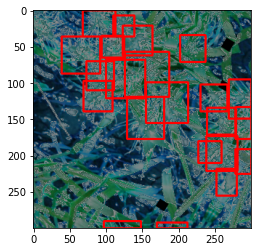

Inference time: 0.4576389789581299
Boxes: 0
Mod time: 0.004410505294799805
NMS time: 4.935264587402344e-05


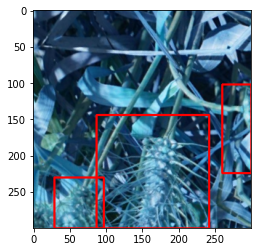

Inference time: 0.46529555320739746
Boxes: 28
Mod time: 0.004526376724243164
NMS time: 0.0009682178497314453
156 32 197 86 wheat 0.8588701
155 266 193 305 wheat 0.82983214
243 59 279 106 wheat 0.82799363
258 -8 295 48 wheat 0.7536835
231 236 264 285 wheat 0.69383866
228 7 264 58 wheat 0.626623
52 83 83 129 wheat 0.59682894
0 44 35 104 wheat 0.56665844
141 182 175 239 wheat 0.5252226
77 201 111 256 wheat 0.5002508


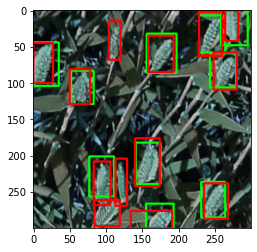

Inference time: 0.4541327953338623
Boxes: 23
Mod time: 0.004441976547241211
NMS time: 0.0010213851928710938
29 121 69 174 wheat 0.8325937
237 184 275 223 wheat 0.7554474
50 204 97 236 wheat 0.686758
67 258 107 293 wheat 0.6811927
36 57 76 97 wheat 0.6760996
92 123 131 160 wheat 0.6359706
115 179 155 225 wheat 0.6247685
26 8 64 37 wheat 0.5947476
141 117 175 151 wheat 0.5296768
196 159 239 196 wheat 0.5066728


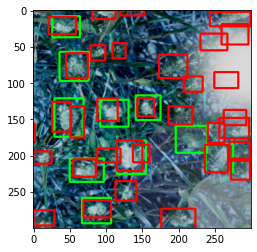

Inference time: 0.4753234386444092
Boxes: 0
Mod time: 0.0048258304595947266
NMS time: 5.53131103515625e-05


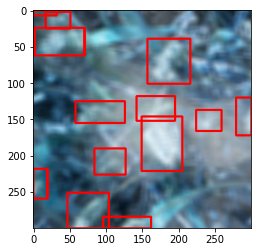

Inference time: 0.45863986015319824
Boxes: 0
Mod time: 0.004753589630126953
NMS time: 5.435943603515625e-05


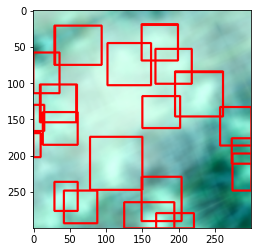

Inference time: 0.4558537006378174
Boxes: 1
Mod time: 0.005018711090087891
NMS time: 0.0009164810180664062
248 75 299 139 wheat 0.57312155


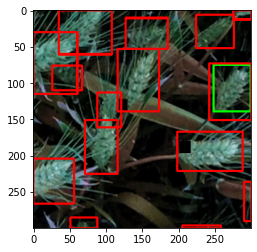

Inference time: 0.49711132049560547
Boxes: 7
Mod time: 0.004417896270751953
NMS time: 0.001016378402709961
107 4 154 57 wheat 0.7216406
81 56 119 102 wheat 0.6022881
182 140 219 180 wheat 0.5523897


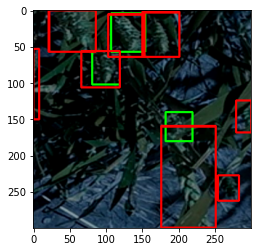

Inference time: 0.5032095909118652
Boxes: 4
Mod time: 0.00461888313293457
NMS time: 0.0010142326354980469
208 -4 248 51 wheat 0.550061
60 265 99 302 wheat 0.5110218
229 166 267 221 wheat 0.50454706


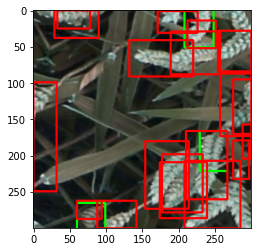

Inference time: 0.4804844856262207
Boxes: 0
Mod time: 0.004209756851196289
NMS time: 4.863739013671875e-05


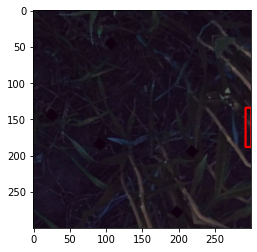

Inference time: 0.4609377384185791
Boxes: 0
Mod time: 0.004458189010620117
NMS time: 5.316734313964844e-05


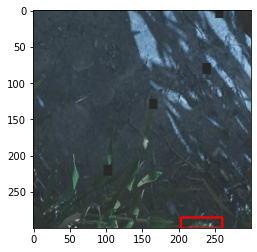

Inference time: 0.4641101360321045
Boxes: 3
Mod time: 0.004714012145996094
NMS time: 0.0009267330169677734
186 51 225 85 wheat 0.5476339
123 42 166 76 wheat 0.51979476


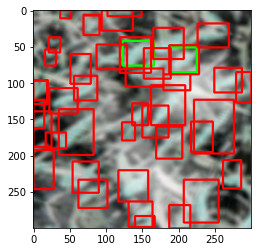

Inference time: 0.4593336582183838
Boxes: 0
Mod time: 0.004602909088134766
NMS time: 5.459785461425781e-05


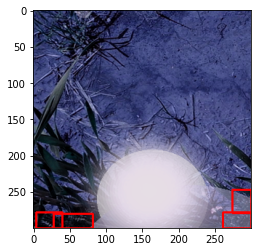

In [ ]:
dboxes = default_boxes_300()
test_pytorch('./ssd300.pth', SSD(ResNet50Backbone(), classes=2), BoxUtils(dboxes), val_dataset_fold, size=300, thresh=0.1, num=15)

###Convert model to ONNX 


In [ ]:

onnx_model_path = "ssd300.onnx"

model = SSD(ResNet50Backbone(), classes=2).cpu()
state = torch.load('./ssd300.pth')
model.load_state_dict(state)
model.eval()

dummy_input = torch.randn(1, 3, 300, 300)
torch.onnx.export(model, dummy_input, onnx_model_path, verbose=True, output_names=["rboxes", "rlabels"])

graph(%input.1 : Float(1, 3, 300, 300, strides=[270000, 90000, 300, 1], requires_grad=0, device=cpu),
      %loc.0.weight : Float(16, 1024, 3, 3, strides=[9216, 9, 3, 1], requires_grad=1, device=cpu),
      %loc.0.bias : Float(16, strides=[1], requires_grad=1, device=cpu),
      %loc.1.weight : Float(24, 512, 3, 3, strides=[4608, 9, 3, 1], requires_grad=1, device=cpu),
      %loc.1.bias : Float(24, strides=[1], requires_grad=1, device=cpu),
      %loc.2.weight : Float(24, 512, 3, 3, strides=[4608, 9, 3, 1], requires_grad=1, device=cpu),
      %loc.2.bias : Float(24, strides=[1], requires_grad=1, device=cpu),
      %loc.3.weight : Float(24, 256, 3, 3, strides=[2304, 9, 3, 1], requires_grad=1, device=cpu),
      %loc.3.bias : Float(24, strides=[1], requires_grad=1, device=cpu),
      %loc.4.weight : Float(16, 256, 3, 3, strides=[2304, 9, 3, 1], requires_grad=1, device=cpu),
      %loc.4.bias : Float(16, strides=[1], requires_grad=1, device=cpu),
      %loc.5.weight : Float(16, 256, 3, 3,

###Visualization of the result (openCV)

In [ ]:
# load model
net =  cv2.dnn.readNetFromONNX(onnx_model_path) 

def test_openCV(model_path, model_class, bu, input, num=6, thresh=0.7, iou_threshold=0.5, size=300, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    classes = [
        "bg", 'wheat'
    ]

    total = 0

    for img, target in input:
        img = img.view((1,)+img.shape)
        st = time.time()
        net.setInput(img.numpy())
        rboxes, rlabels = net.forward(["rboxes", "rlabels"])
        print('Inference time:', time.time()-st)
        rboxes = torch.tensor(rboxes)
        rlabels = torch.tensor(rlabels)

        st = time.time()

        rboxes, rlabels = rboxes[0].transpose(1,0), rlabels[0]
        img = (denorm(img[0].numpy().transpose(1,2,0).copy())*255).astype(np.uint8)
        w,h = img.shape[:2]

        bboxes = bu.decode(rboxes)
        scores, labels = F.softmax(rlabels, dim=0).max(dim=0)
        mask = (labels > 0)
        labels = labels[mask]
        scores = scores[mask]
        bboxes = bboxes[mask]

        mask = (scores > thresh)
        labels = labels[mask]
        scores = scores[mask]
        bboxes = bboxes[mask]
        
        
        print('Boxes:',bboxes.shape[0])
        print('Mod time:', time.time()-st)
        st = time.time()
        idx = batched_nms(bboxes, scores, labels, iou_threshold=iou_threshold).numpy().astype(np.uint64)
        print('NMS time:', time.time()-st)
        labels = labels.detach().numpy().astype(np.uint8)
        scores = scores.detach().numpy()
        bboxes = bboxes.detach().numpy()

        # drow pred bbox
        for i in idx:
            b = bboxes[i] 
            img = cv2.rectangle(img, (int(b[0]*size), int(b[1]*size)), (int(b[2]*size), int(b[3]*size)), (0, 255, 0), 2)
            img = cv2.putText(img, str(scores[i]), (int(b[0]*size) - 10, int(b[1]*size) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            print(int(b[0]*size), int(b[1]*size), int(b[2]*size), int(b[3]*size), classes[labels[i]], scores[i])

        bboxs =  bu.decode(target[0])
        labels = target[1]
        # drow gt bbox
        for b, l in zip(bboxs, labels):
          if int(l) != 0:
              img = cv2.rectangle(img, (int(b[0]*size), int(b[1]*size)), (int(b[2]*size), int(b[3]*size)), (255, 0, 0), 2)       
        plt.figure(figsize=(12,12))
        plt.imshow(img)
        plt.show()

        total += 1
        if total >= num:
            break



# https://pytorch.org/hub/pytorch_vision_densenet/
# model = torch.hub.load('pytorch/vision:v0.6.0', 'densenet121', pretrained=True)


Inference time: 0.8365650177001953
Boxes: 16
Mod time: 0.0046961307525634766
NMS time: 0.0005991458892822266
132 50 178 84 wheat 0.5944406
38 146 84 187 wheat 0.58805317
63 242 124 272 wheat 0.5850982
27 108 85 136 wheat 0.55281276
193 -2 228 43 wheat 0.54484886
115 181 159 218 wheat 0.53362113
268 190 303 221 wheat 0.5083827
193 108 231 139 wheat 0.50429344


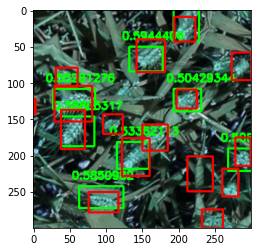

Inference time: 0.8698315620422363
Boxes: 10
Mod time: 0.004537343978881836
NMS time: 0.00044083595275878906
245 230 290 267 wheat 0.54870224
254 74 293 107 wheat 0.54564035
28 53 72 89 wheat 0.53902936
194 120 228 163 wheat 0.5340845
23 175 71 210 wheat 0.5302374
263 185 298 220 wheat 0.5167509
249 4 285 36 wheat 0.5026143


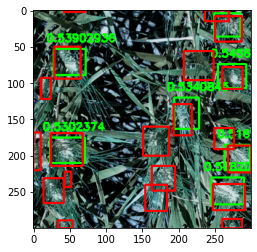

Inference time: 0.8531873226165771
Boxes: 11
Mod time: 0.0047757625579833984
NMS time: 0.0005700588226318359
223 132 256 169 wheat 0.61391747
274 261 301 293 wheat 0.51966196
111 142 149 177 wheat 0.5158921
123 244 164 277 wheat 0.5112828
164 20 204 52 wheat 0.51062167
66 193 102 233 wheat 0.50769496
185 91 223 127 wheat 0.50202525


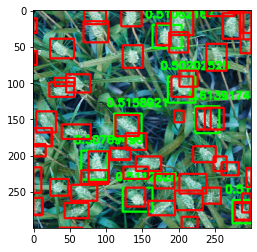

Inference time: 0.8431768417358398
Boxes: 19
Mod time: 0.0047571659088134766
NMS time: 0.0013964176177978516
206 168 238 209 wheat 0.60503525
249 126 283 168 wheat 0.58788085
88 242 118 284 wheat 0.564111
78 119 131 148 wheat 0.55379164
151 91 185 125 wheat 0.5379502
177 28 217 64 wheat 0.5339717
164 60 202 94 wheat 0.51643884
218 244 253 290 wheat 0.50987756


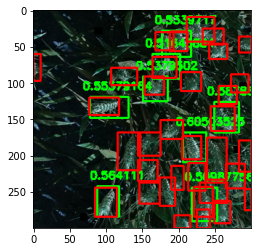

Inference time: 0.8489890098571777
Boxes: 4
Mod time: 0.004970073699951172
NMS time: 0.0005965232849121094
258 230 298 266 wheat 0.5927489
7 8 64 48 wheat 0.54564226


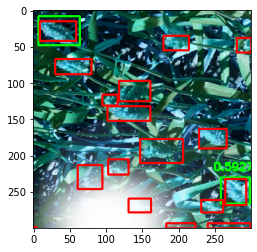

Inference time: 0.843327522277832
Boxes: 25
Mod time: 0.004476070404052734
NMS time: 0.0009553432464599609
101 219 144 253 wheat 0.6884398
212 197 251 232 wheat 0.591955
219 -2 262 22 wheat 0.5817148
137 172 172 203 wheat 0.56478345
24 104 51 147 wheat 0.55460167
57 196 91 226 wheat 0.54193425
101 82 133 116 wheat 0.5412549
11 215 57 246 wheat 0.5393277
167 131 206 179 wheat 0.5359027
61 153 90 189 wheat 0.5339632
75 39 102 74 wheat 0.5092973
210 33 242 70 wheat 0.50731814


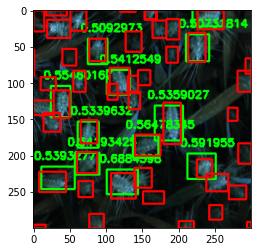

Inference time: 0.8648571968078613
Boxes: 2
Mod time: 0.004607677459716797
NMS time: 0.0009622573852539062
235 134 277 176 wheat 0.5230883
204 139 245 184 wheat 0.506049


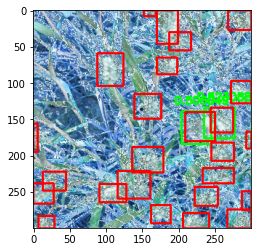

Inference time: 0.8507499694824219
Boxes: 0
Mod time: 0.004828453063964844
NMS time: 6.365776062011719e-05


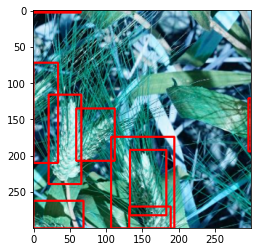

Inference time: 0.8693711757659912
Boxes: 0
Mod time: 0.004781484603881836
NMS time: 6.103515625e-05


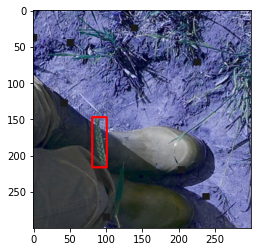

Inference time: 0.8439576625823975
Boxes: 38
Mod time: 0.004394054412841797
NMS time: 0.0009472370147705078
182 50 219 91 wheat 0.6834834
117 133 149 157 wheat 0.60889834
241 265 278 292 wheat 0.60395545
75 228 104 251 wheat 0.60054904
125 72 165 104 wheat 0.5979521
40 44 76 79 wheat 0.5714805
202 141 231 162 wheat 0.5556419
124 195 150 226 wheat 0.5554609
143 236 173 261 wheat 0.54721844
13 248 57 284 wheat 0.5426959
29 149 52 177 wheat 0.5195281
271 154 297 185 wheat 0.5184952
229 63 259 101 wheat 0.5177664
279 53 301 87 wheat 0.5174945
220 220 264 252 wheat 0.5168982
177 16 214 45 wheat 0.5166969


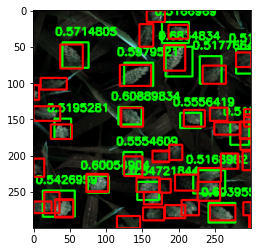

Inference time: 0.8500714302062988
Boxes: 1
Mod time: 0.004445552825927734
NMS time: 0.0008955001831054688
88 150 136 179 wheat 0.50558114


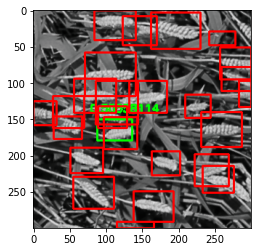

Inference time: 0.8521714210510254
Boxes: 25
Mod time: 0.0044689178466796875
NMS time: 0.0009229183197021484
223 207 249 247 wheat 0.5749558
234 42 270 82 wheat 0.5480459
184 124 233 168 wheat 0.54569787
114 123 161 166 wheat 0.5454131
178 43 218 85 wheat 0.5402998
21 265 71 291 wheat 0.5307669
175 215 219 251 wheat 0.5286541
49 24 152 83 wheat 0.52268445
12 132 47 175 wheat 0.51743263
154 248 199 280 wheat 0.50036734


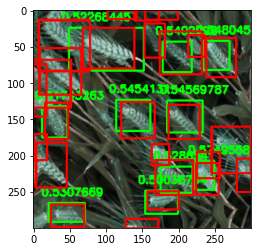

Inference time: 0.8804669380187988
Boxes: 3
Mod time: 0.00616455078125
NMS time: 0.0015931129455566406
279 186 306 247 wheat 0.5685108


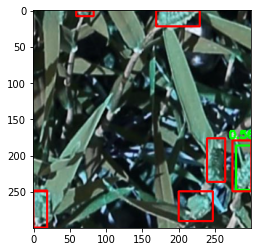

Inference time: 0.8736791610717773
Boxes: 7
Mod time: 0.004488706588745117
NMS time: 0.001119375228881836
230 220 272 252 wheat 0.6439485
23 135 70 180 wheat 0.5170554
169 -3 212 24 wheat 0.5122359


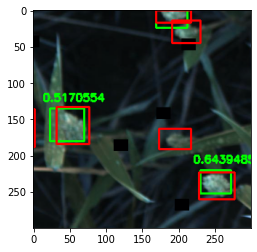

Inference time: 0.8741810321807861
Boxes: 3
Mod time: 0.0051860809326171875
NMS time: 0.00048804283142089844
8 103 41 159 wheat 0.54823476
97 127 140 172 wheat 0.516071


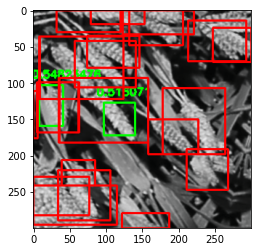

In [ ]:
dboxes = default_boxes_300()
test_openCV('./ssd300.pth', SSD(ResNet50Backbone(), classes=2), BoxUtils(dboxes), val_dataset_fold, size=300, thresh=0.1, num=15, iou_threshold=0.3,)